In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt

%matplotlib inline

/home/beams/TOMO/conda/anaconda/envs/tomocupy/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
astropy module not found
olefile module not found


# Init data sizes and parametes of the PXM of ID16A

In [2]:
n = 384  # object size in x,y
nz = 384  # object size in z    
ntheta = 1  # number of angles (rotations)

pnz = nz # tomography chunk size for GPU processing (dont change if data is small and fits gpu memory)
ptheta = ntheta # holography chunk size for GPU processing

center = n/2 # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32') # projection angles

# ID16a setup
voxelsize = 1e-6*2048/n # [cm] object voxel size 
energy = 33.35  # [keV] x-ray energy    
focusToDetectorDistance = 128 # [cm]
sx0 = 0.037 # [cm] motor offset from the focal spot
z1 = np.array([0.4584,0.4765,0.5488,0.69895])-sx0 # distances between planes and the focal spot
z2 = focusToDetectorDistance-z1 # distances between planes and the detector
magnifications = focusToDetectorDistance/z1 # actual magnifications
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/focusToDetectorDistance # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

## Read data and flat fields

In [3]:
data = np.zeros([len(distances),ntheta,nz,n],dtype='float32')
flat = np.zeros([len(distances),1,nz,n],dtype='float32')
for k in range(4):
    data[k] = dxchange.read_tiff(f'data/modeling/data_phantom_{n}_{k}.tiff')[:ntheta]
    flat[k] = dxchange.read_tiff(f'data/modeling/flat_phantom_{n}_{k}.tiff')[:]

# Divide by flat fields

In [4]:
data/=flat

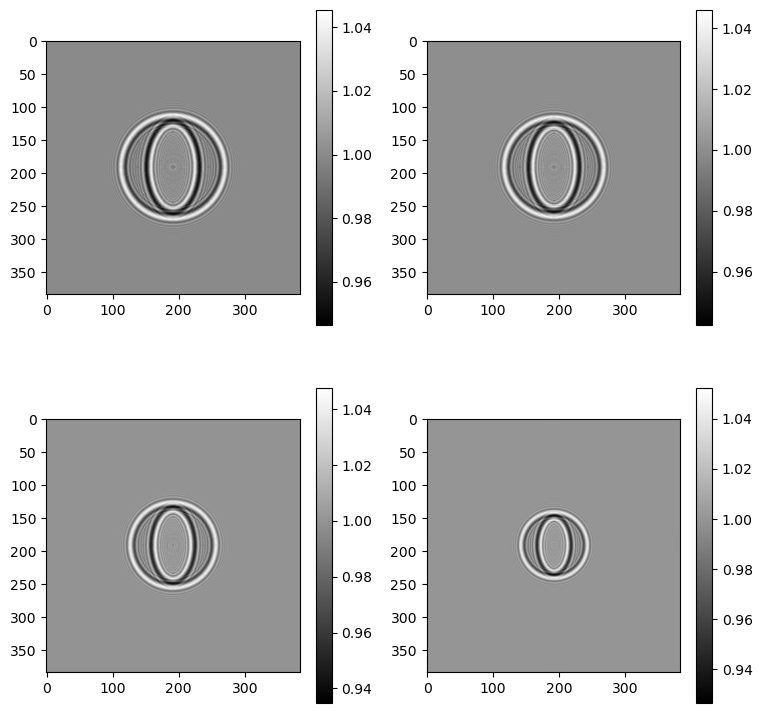

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0],cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0],cmap='gray')
fig.colorbar(im)

## Scale everything to one magnification

In [6]:
import scipy.ndimage as ndimage
for k in range(len(distances)):
    datas = ndimage.zoom(data[k],(1,1/norm_magnifications[k],1/norm_magnifications[k]))
    ne = datas.shape[-1]
    data[k] = datas[:,ne//2-n//2:ne//2+n//2,ne//2-n//2:ne//2+n//2]

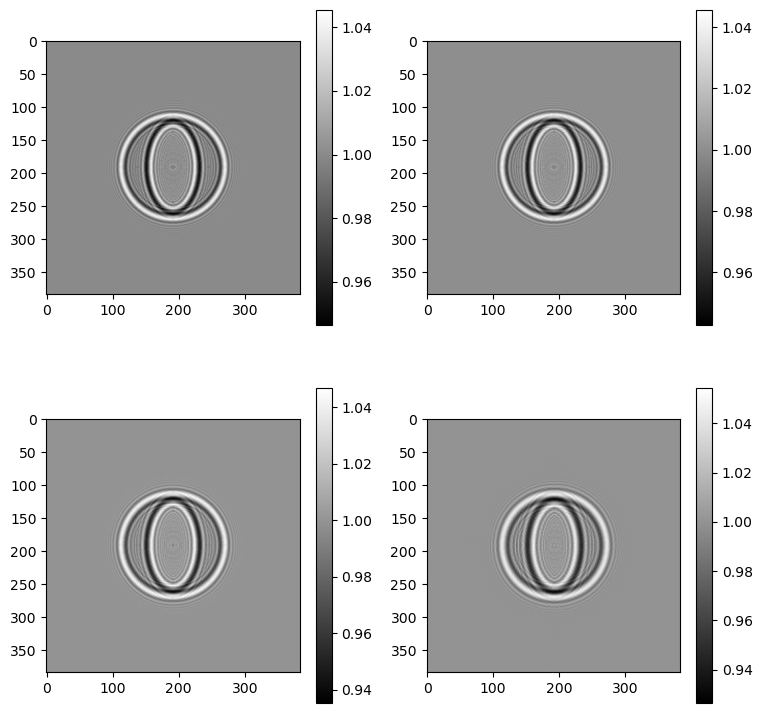

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,0],cmap='gray')
fig.colorbar(im)
im=axs[1,1].imshow(data[3,0],cmap='gray')
fig.colorbar(im)

# Solve with the MultiPaganin method 

In [8]:
def multiPaganin(rads, wlen, dists, delta_beta, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function. This 
    method relies on linearization of the direct problem, based  on  the
    first  order  Taylor expansion of the transmittance function.
    Found in Yu et al. 2018 and adapted from Cloetens et al. 1999


    Parameters
    ----------
    rad : 2D-array
        projection.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dist : float
        Object to detector distance (propagation distance) in mm.
    delta : float    
        refractive index decrement
    beta : float    
        absorption index
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space
    """    
    numerator = 0
    denominator = 0    
    for j in range(0, len(dists)):    
        rad_freq = np.fft.fft2(rads[j])    
        taylorExp = 1 + wlen * dists[j] * np.pi * (delta_beta) * (fx**2+fy**2)
        numerator = numerator + taylorExp * (rad_freq)
        denominator = denominator + taylorExp**2 

    numerator = numerator / len(dists)
    denominator = (denominator / len(dists)) + alpha

    phase = np.log(np.real(  np.fft.ifft2(numerator / denominator) ))    
    phase = (delta_beta) * 0.5 * phase

    
    return phase

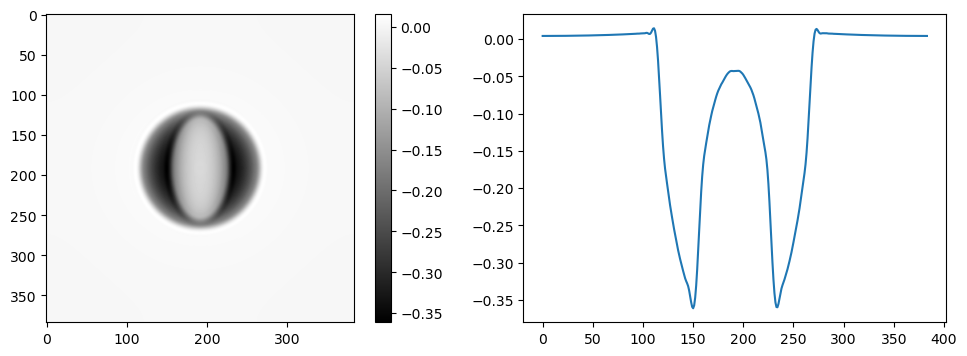

In [12]:
rads = data[:,0]
fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)
alpha = 1e-7
wlen = 1.23984198e-7/33.35
delta_beta = 2.3754525801944482e-07/9.488849121350568e-11
rec = multiPaganin(rads, wlen, distances, delta_beta, fx, fy, alpha)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
im=axs[0].imshow(rec,cmap='gray')
fig.colorbar(im)
im=axs[1].plot(rec[nz//2])

# Solve with the CTF method 

In [10]:
def CTF(rads, wlen, dists, fx, fy, alpha):
    """
    Phase retrieval method based on Contrast Transfer Function.    This 
    method assumes weak absoprtion and slowly varying phase shift.
    Derived from Langer et al., 2008: Quantitative comparison of direct
    phase retrieval algorithms.

    Parameters
    ----------
    rads : list of 2D-array
        Elements of the list correspond to projections of the sample
        taken at different distance. One projection per element.
    wlen : float
        X-ray wavelentgth assumes monochromatic source.
    dists : list of float
        Object to detector distance (propagation distance) in mm. One 
        distance per element.
    fx, fy : ndarray
        Fourier conjugate / spatial frequency coordinates of x and y.
    alpha : float
        regularization factor.
        
    Return
    ------

    phase retrieved projection in real space

    """

    A = np.zeros((rads[0].shape[0], rads[0].shape[1]))
    B = np.zeros((rads[0].shape[0], rads[0].shape[1]))
    C = np.zeros((rads[0].shape[0], rads[0].shape[1]))
    E = np.zeros((rads[0].shape[0], rads[0].shape[1]))
    F = np.zeros((rads[0].shape[0], rads[0].shape[1]))

    for j in range(0,len(dists)):
        sin = 2*np.sin(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
        cos = 2*np.cos(np.pi*wlen*dists[j]*(fx**2+fy**2)) 
        A = A + sin * cos
        B = B + sin * sin
        C = C + cos * cos
        rad_freq = np.fft.fft2(rads[j])
        E = E + rad_freq * sin
        F = F + rad_freq * cos
    A = A / len(dists)
    B = B / len(dists)
    C = C / len(dists)    
    Delta = B * C - A**2
    
    phase = (C * E - A * F)    * (1 / (2*Delta+alpha)) 
    phase[0,0] = 0. + 0.j
    phase = np.fft.ifft2(phase)
    phase = np.real(phase)

    return -phase


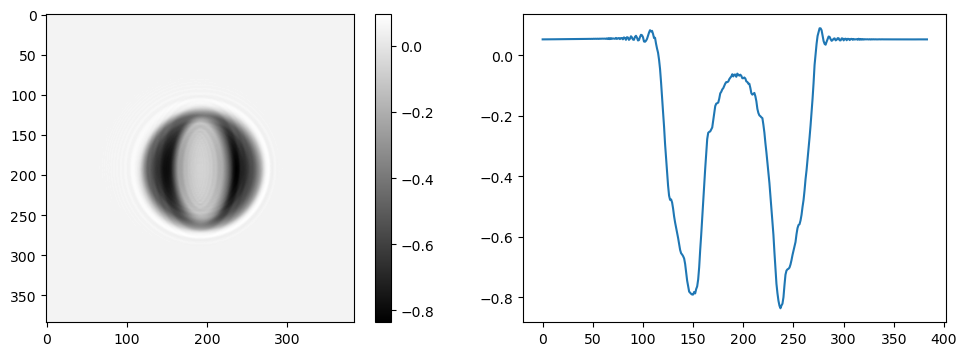

In [11]:
rads = data[:,0]
fx = np.fft.fftfreq(n,d=voxelsize)
[fx,fy] = np.meshgrid(fx,fx)
alpha = 1e-12
wlen = 1.23984198e-7/33.35
rec = CTF(rads, wlen, distances, fx, fy, alpha)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
im=axs[0].imshow(rec,cmap='gray')
fig.colorbar(im)
im=axs[1].plot(rec[nz//2])